In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import random

# Problem 1

In [2]:
data = loadmat('./data/FoCOwxSept.mat')

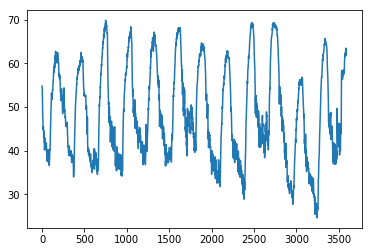

In [3]:
plt.plot(data['Temp'])

In [4]:
def get_embedding(X, T=1):
    X = np.array(X)
    res = np.zeros((X.shape[0]-3*T, 3))
    y = np.zeros((X.shape[0]-3*T))
    for i in range(3*T, res.shape[0]+3*T):
        res[i-3*T] = [X[i-T], X[i-2*T], X[i-3*T]]
        y[i-3*T] = X[i]
    return res, y

In [5]:
def plot_time_delay_embedding(embed_x):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(embed_x[:, 0], embed_x[:, 1], zs=embed_x[:, 2], marker='.')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(30, 145)
    plt.show()

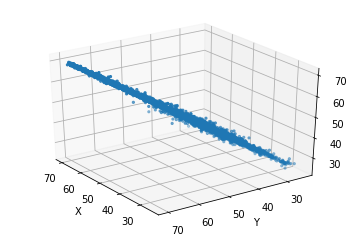

In [6]:
plot_time_delay_embedding(get_embedding(data['Temp'], 1)[0])

In [7]:
# split training, validation and testing
def get_train_val_test(data, train_val_split = 9):
    x, y = get_embedding(data['Temp'], 1)
    test_x = x[-500:, :].T
    test_y = y[-500:].reshape(1, 500)

    val_inds = np.random.choice(x.shape[0]-500, (x.shape[0]-500)//train_val_split, replace=False)
#     print(len(set(val_inds)) == len(val_inds))
    train_inds = np.setdiff1d(range(x.shape[0]-500), val_inds)
    train_x = x[train_inds, :].T
    train_y = y[train_inds].reshape(1, len(train_inds))
    val_x = x[val_inds, :].T
    val_y = y[val_inds].reshape(1, len(val_inds))
    print(train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape)
    return train_x, train_y, val_x, val_y, test_x, test_y

In [8]:
train_x, train_y, val_x, val_y, test_x, test_y = get_train_val_test(data, 9)

(3, 2745) (1, 2745) (3, 343) (1, 343) (3, 500) (1, 500)


# Problem 2

In [9]:
def distortion_error(X, centers, x_center_mapping):
    res = 0
    for i in range(X.shape[1]):
        res += np.linalg.norm(X[:, i] - centers[:, x_center_mapping[i]])
    return res/X.shape[1]

def LBG(X, Nc):
    n, p = X.shape
    centers = np.random.rand(n, Nc)  # randomly intialize Nc centers
    x_center_mapping = [0 for i in range(p)]
    
    e_threshold = 0.01
    for i in range(100):
        e = distortion_error(X, centers, x_center_mapping) 
        if e <= e_threshold:
            break
        voronoi_set_sum = np.zeros((n, Nc))
        voronoi_set_cnt = np.array([0 for i in range(Nc)])
        for i in range(p):
            distances = [np.linalg.norm(centers[:, k] - X[:, i]) for k in range(Nc)]
            closest_ind = np.argmin(distances)
            x_center_mapping[i] = closest_ind
            voronoi_set_sum[:, closest_ind] += X[:, i]
            voronoi_set_cnt[closest_ind] += 1
        for i in range(Nc):
            if voronoi_set_cnt[i] != 0:
                centers[:, i] = voronoi_set_sum[:, i]/voronoi_set_cnt[i]
    return centers

In [10]:
def phi(r, alpha=1, method=0):
    '''
    This defines the radial basis functions
    Method ranges from 0 to 5 (inclusive)
    '''
    if method == 0:
        return r
    elif method == 1:
        return r*r*np.log(r+0.001)
    elif method == 2:
        return r**3
    elif method == 3:
        return np.exp(-(r/alpha)**2)
    elif method == 4:
        return np.sqrt(alpha**2 + r**2)
    elif method == 5:
        return 1/np.sqrt(alpha**2 + r**2)
    else:
        raise ValueError('%s is not an acceptable RBF method' % method)

def get_centers(X, Nc, center_choice, pre_centers=None):
    if center_choice=='rand':
        center_inds = random.sample(range(X.shape[1]), Nc)
        return X[:, center_inds]
    elif center_choice == 'lbg':
        return LBG(X, Nc)
    elif center_choice == 'pre':
        return pre_centers
    else:
        raise ValueError('%s is not a valid center_choice' % center_choice)
    
def get_PHI(X, centers, rbf_func, rbf_alpha=None):
    p = X.shape[1]
    Nc = centers.shape[1]
    PHI = np.ones((p, Nc+1))
    for i in range(p):
        for j in range(1, Nc+1):
            PHI[i][j] = phi(np.linalg.norm(X[:, i] - centers[:, j-1]), rbf_alpha, rbf_func)
    return PHI

def RBF_train(X, Y, Nc, center_choice, rbf_func, rbf_alpha=None, pre_centers=None):
    '''
    @:Nc: Number of centers
    '''
    X = np.array(X)
    centers = get_centers(X, Nc, center_choice, pre_centers).reshape((-1, Nc))
    PHI = get_PHI(X, centers, rbf_func, rbf_alpha)
    u, s, vh = np.linalg.svd(PHI)
    tmp = np.vstack((np.diag(s), np.zeros((u.shape[0] - s.shape[0], vh.shape[0]))))  # transform s to matrix
    w = vh.T @ np.linalg.pinv(tmp) @ u.T @ Y.T
    
    return w, centers, PHI

def RBF_test(X_test, w, centers, Y_true, rbf_func, rbf_alpha=None):
    PHI = get_PHI(X_test, centers, rbf_func, rbf_alpha)
    y_pred = PHI @ w
    
    return y_pred, model_error(X_test, y_pred, Y_true)

In [11]:
def model_error(X_test, y_pred, Y_true):
    error = np.sum((y_pred - Y_true.reshape(y_pred.shape))**2) / np.sum((Y_true.reshape(y_pred.shape) - np.mean(X_test, axis=0).reshape(y_pred.shape))**2)
    return error

### Test different number of centers - rand

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

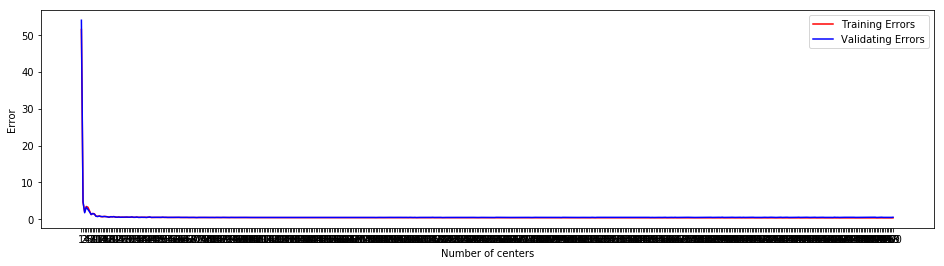

In [24]:
train_errors = []
val_errors = []
min_val_error = 10
best_w = None
best_centers = None
max_center_no = 500
for i in range(1, max_center_no+1):
    w, centers, PHI = RBF_train(train_x, train_y, Nc=i, center_choice='rand',rbf_func=0, rbf_alpha=1)
    print(i, end=' ')
    _, t_error = RBF_test(train_x, w, centers, train_y, rbf_func=0, rbf_alpha=1)
    _, v_error = RBF_test(val_x, w, centers, val_y, rbf_func=0, rbf_alpha=1)
    train_errors.append(t_error)
    val_errors.append(v_error)
    if v_error < min_val_error:
        min_val_error = v_error
        best_w = w
        best_centers = centers

print(best_centers.shape)
np.save('./best_centers1.npy', best_centers)
np.save('./best_w1.npy', best_w)
plt.figure(figsize=(16, 4))
plt.plot(range(1, max_center_no+1), train_errors, 'r', label='Training Errors')
plt.plot(range(1, max_center_no+1), val_errors, 'b', label='Validating Errors')
plt.xticks(range(1,max_center_no+1))
plt.ylabel('Error')
plt.xlabel('Number of centers')
plt.legend()
plt.show()

### Test different number of centers - lbg

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 (3, 21)


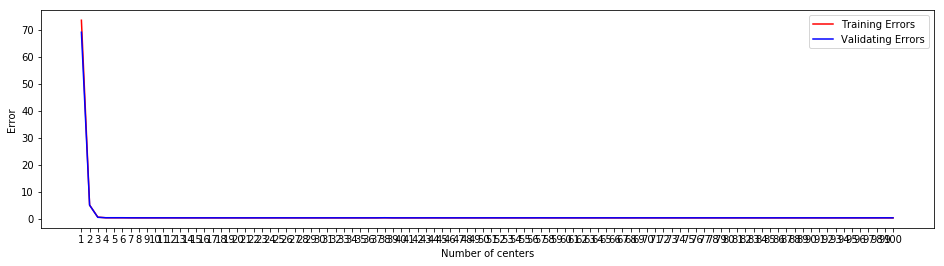

In [25]:
train_errors = []
val_errors = []
min_val_error = 100
best_w = None
best_centers = None
max_center_no = 100
for i in range(1, max_center_no+1):
    w, centers, PHI = RBF_train(train_x, train_y, Nc=i, center_choice='lbg',rbf_func=0, rbf_alpha=1)
    print(i, end=' ')
    _, t_error = RBF_test(train_x, w, centers, train_y, rbf_func=0, rbf_alpha=1)
    _, v_error = RBF_test(val_x, w, centers, val_y, rbf_func=0, rbf_alpha=1)
    train_errors.append(t_error)
    val_errors.append(v_error)
    if v_error < min_val_error:
        min_val_error = v_error
        best_w = w
        best_centers = centers

print(best_centers.shape)
np.save('./best_centers2.npy', best_centers)
np.save('./best_w2.npy', best_w)
plt.figure(figsize=(16, 4))
plt.plot(range(1, max_center_no+1), train_errors, 'r', label='Training Errors')
plt.plot(range(1, max_center_no+1), val_errors, 'b', label='Validating Errors')
plt.xticks(range(1,max_center_no+1))
plt.ylabel('Error')
plt.xlabel('Number of centers')
plt.legend()
plt.show()

### Test different RBF functions, using rand centers

In [102]:
best_centers = np.load('./best_centers1.npy')
best_w = np.load('./best_w1.npy')
_, v_error = RBF_test(val_x, best_w, best_centers, val_y, rbf_func=0, rbf_alpha=0)
print(v_error)

min_error = 1
for i in range(1, 3):
    w, centers, PHI = RBF_train(train_x, train_y, Nc=best_centers.shape[1], center_choice='pre', rbf_func=i, rbf_alpha=0, pre_centers=best_centers)
    _, v_error = RBF_test(val_x, w, centers, val_y, rbf_func=i, rbf_alpha=0)
    print('method:', i, v_error)

0.5544184569234872
method: 1 0.5693139370927809
method: 2 0.5624783124122748


----- 3|2.91
----- 3|2.96
----- 4|0.01
----- 4|0.06
----- 4|0.11
----- 4|0.16
----- 4|0.21
----- 4|0.26
----- 4|0.31
----- 4|0.36
----- 4|0.41
----- 4|0.46
----- 4|0.51
----- 4|0.56
----- 4|0.61
----- 4|0.66
----- 4|0.71
----- 4|0.76
----- 4|0.81
----- 4|0.86
----- 4|0.91
----- 4|0.96
----- 4|1.01
----- 4|1.06
----- 4|1.11
----- 4|1.16
----- 4|1.21
----- 4|1.26
----- 4|1.31
----- 4|1.36
----- 4|1.41
----- 4|1.46
----- 4|1.51
----- 4|1.56
----- 4|1.61
----- 4|1.66
----- 4|1.71
----- 4|1.76
----- 4|1.81
----- 4|1.86
----- 4|1.91
----- 4|1.96
----- 4|2.01
----- 4|2.06
----- 4|2.11
----- 4|2.16
----- 4|2.21
----- 4|2.26
----- 4|2.31
----- 4|2.36
----- 4|2.41
----- 4|2.46
----- 4|2.51
----- 4|2.56
----- 4|2.61
----- 4|2.66
----- 4|2.71
----- 4|2.76
----- 4|2.81
----- 4|2.86
----- 4|2.91
----- 4|2.96
***** 0.5553626503098771


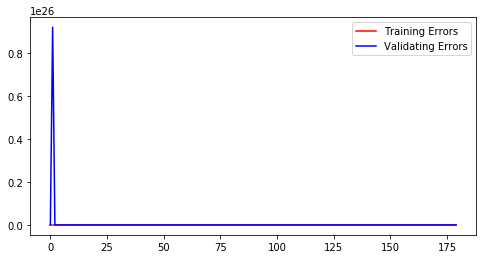

In [106]:
best_centers = np.load('./best_centers1.npy')
min_error = 1
train_errors = []
val_errors = []
for i in range(3, 6):
    for j in np.arange(0.01, 3, 0.05):
#         print('%d|%.2f' % (i, j), end=' ')
        w, centers, PHI = RBF_train(train_x, train_y, Nc=best_centers.shape[1], center_choice='pre', rbf_func=i, rbf_alpha=j, pre_centers=best_centers)
        _, t_error = RBF_test(train_x, w, centers, train_y, rbf_func=i, rbf_alpha=j)
        _, v_error = RBF_test(val_x, w, centers, val_y, rbf_func=i, rbf_alpha=j)
        train_errors.append(t_error)
        val_errors.append(v_error)
        if v_error < min_error:
            min_error = v_error
            print('-'*5, '%d|%.2f' % (i, j))

# np.save('./train_errors2.npy', train_errors)
# np.save('./val_errors2.npy', val_errors)
print('*'*5, min_error)
plt.figure(figsize=(8, 4))
plt.plot(train_errors, 'r', label='Training Errors')
plt.plot(val_errors, 'b', label='Validating Errors')
plt.legend()
plt.show()

### Test different RBF functions with alpha=1, using best centers from lbg

In [107]:
best_centers = np.load('./best_centers2.npy')
best_w = np.load('./best_w2.npy')
_, v_error = RBF_test(test_x, best_w, best_centers, test_y, rbf_func=0, rbf_alpha=0)
print(v_error)

min_error = 1
for i in range(1, 3):
    w, centers, PHI = RBF_train(train_x, train_y, Nc=best_centers.shape[1], center_choice='pre', rbf_func=i, rbf_alpha=0, pre_centers=best_centers)
    _, v_error = RBF_test(val_x, w, centers, val_y, rbf_func=i, rbf_alpha=0)
    print('method:', i, v_error)

0.5994893180630592
method: 1 0.5527377007578017
method: 2 0.5390256331277168


----- 4|0.01
----- 4|0.06
----- 4|0.16
----- 4|0.26
----- 4|0.36
***** 0.5432126302876285


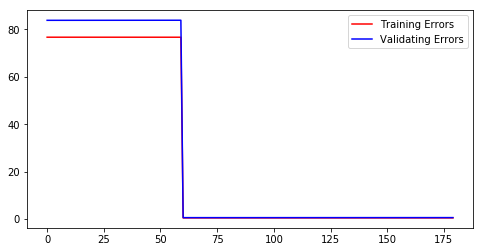

In [108]:
best_centers = np.load('./best_centers2.npy')
train_errors = []
val_errors = []

for i in range(3, 6):
    for j in np.arange(0.01, 3, 0.05):
#         print('%d|%.2f' % (i, j), end=' ')
        w, centers, PHI = RBF_train(train_x, train_y, Nc=best_centers.shape[1], center_choice='pre', rbf_func=i, rbf_alpha=j, pre_centers=best_centers)
        _, t_error = RBF_test(train_x, w, centers, train_y, rbf_func=i, rbf_alpha=j)
        _, v_error = RBF_test(val_x, w, centers, val_y, rbf_func=i, rbf_alpha=j)
        train_errors.append(t_error)
        val_errors.append(v_error)
        if v_error < min_error:
            min_error = v_error
            print('-'*5, '%d|%.2f' % (i, j))

# np.save('./train_errors2.npy', train_errors)
# np.save('./val_errors2.npy', val_errors)
print('*'*5, min_error)
plt.figure(figsize=(8, 4))
plt.plot(train_errors, 'r', label='Training Errors')
plt.plot(val_errors, 'b', label='Validating Errors')
plt.legend()
plt.show()

## Best RBF model
LBG method; 21 centers; RBF_method2 with val_error: 0.5390256331277168 

Test error: 0.5334181027213382

In [111]:
np.hstack((train_x, val_x)).shape

(3, 3088)

In [112]:
# Retrain on both training and validation data, and run it on test
w, centers, PHI = RBF_train(np.hstack((train_x, val_x)), np.hstack((train_y, val_y)), Nc=21, center_choice='lbg',rbf_func=2, rbf_alpha=1)
# print(i, end=' ')
_, t_error = RBF_test(test_x, w, centers, test_y, rbf_func=2, rbf_alpha=1)
print(t_error)

0.5334181027213382


# Problem 3 - neural network

Note that the input and output have to be transposed here. 

In [79]:
import pickle
class MLP:
    def __init__(self, learning_rate=0.01, batch_size=100, epoch=10, layers=[3], activation='tanh'):
        """
        Parameters here are training parameters
        """
        self.learning_rate=learning_rate
        self.batch_size=batch_size
        self.epoch = epoch    
        self.layers = layers
        self.act_mode = activation
        
        self.weights = []  # can only construct when trainx and trainy are supplied
        self.hidden_states_p = []
        self.hidden_states_s = []
        self.trainx = None
        self.trainy = None
        self.train_mean = None  # for normalizing input data
        self.train_std = None
        
        self._set_modes()
    
    def _set_modes(self):
        if self.act_mode == 'tanh':
            self.act_func = lambda x: 2/(np.expm1(-2*x) + 2) - 1  #np.expm1(2*x)/(np.expm1(2*x) + 2)
            self.act_func_deriv = lambda x: 1 - (self.act_func(x)) ** 2
#             self.y_norm_func = lambda x: (x - np.mean(x, axis=0)[None, :])/np.amax(x - np.mean(x, axis=0)[None, :], axis=0)[None, :]
        elif self.act_mode == 'relu':
            self.act_func = lambda x: x * ((x>0).astype(np.int32))
            self.act_func_deriv = lambda x: (x>0).astype(np.int32)
#             self.y_norm_func = lambda x: x - np.amin(x, axis=0)[None, :]
        else:
            raise ValueError('Activation %s is not recognized!' % act)
    
    def train(self, trainx, trainy, valx, valy):
        train_errors = []
        val_errors = []
        self.trainx, self.trainy = np.copy(trainx), np.copy(trainy)
        if len(self.trainy.shape) == 1:
            self.trainy = self.trainy.reshape(-1, 1)
        if len(self.trainx.shape) == 1:
            self.trainx = self.trainx.reshape(-1, 1)
        self.train_mean = np.mean(self.trainx, axis=0)
        self.train_std = np.std(self.trainx, axis=0)
        self.trainx = (self.trainx - self.train_mean)/self.train_std
#         self.trainx = np.hstack((np.ones((self.trainx.shape[0], 1)), self.trainx))  # append ones to trainx
        self._construct_weights()
        global_i = 0
        for e in range(self.epoch):
            inds = np.random.permutation(np.arange(self.trainx.shape[0]))
            for b in range((self.trainx.shape[0]-1) // self.batch_size + 1):
                batch_inds = inds[b*self.batch_size: np.minimum((b+1)*self.batch_size, self.trainx.shape[0])]
                batchx = self.trainx[batch_inds, :]
                batchy = self.trainy[batch_inds, :]
                forward_out = self._forward(batchx)
                train_step_error = self._backprop(forward_out, batchy)
                train_errors.append(train_step_error)
                val_errors.append(self.validate(valx, valy)[1])
#                 print('step %d: error %.3f' %(global_i, train_step_error))
                global_i += 1
        return train_errors, val_errors
    
    def validate(self, valx, valy):
        valx_norm = (np.copy(valx) - self.train_mean)/self.train_std
        predy = self._forward(valx_norm).reshape(valy.shape)
        error = np.linalg.norm(predy - valy)/valy.shape[0]
        return predy, error
    
    
    def _construct_weights(self):
        self.weights = []
        n_in = self.trainx.shape[1]
        n_out = self.trainy.shape[1]
        weight_shapes = [(n_in, self.layers[0])] + \
                        [(self.layers[i-1], self.layers[i]) for i in range(1, len(self.layers))] + \
                        [(self.layers[-1], n_out)]
        for s in weight_shapes:
            self.weights.append(np.vstack((np.ones((1, s[1])), np.random.normal(0, 0.5, s))))
    
    def _forward(self, batchx):
        self.hidden_states_p = []
        self.hidden_states_s = []
        forward_out = batchx
        self.hidden_states_s.append(np.copy(batchx))
        for w in self.weights[:-1]:
            forward_out = np.hstack((np.ones((forward_out.shape[0], 1)), forward_out))
            forward_out = forward_out @ w
            self.hidden_states_p.append(np.copy(forward_out))
            forward_out = self.act_func(forward_out)
            self.hidden_states_s.append(np.copy(forward_out))
        forward_out = np.hstack((np.ones((forward_out.shape[0], 1)), forward_out))
        forward_out = forward_out @ self.weights[-1]
#         self.hidden_states_p.append(np.copy(forward_out))
        return forward_out
        
    def _backprop(self, y_forward, y_true):
#         print(y_forward.shape, y_true.shape)
        N = y_true.shape[0]
        y_forward = y_forward.reshape(y_true.shape)
        prev_diff = y_forward - y_true
        error = np.linalg.norm(prev_diff)/N
        for i in range(len(self.weights)-1, -1, -1):
            if i != len(self.weights) - 1:
                dSdP = np.copy(prev_diff * self.act_func_deriv(self.hidden_states_p[i]))
            else:
                dSdP = np.copy(prev_diff)
            prev_diff = prev_diff @ self.weights[i][1:, :].T
            dw = (np.hstack((np.ones((self.hidden_states_s[i].shape[0], 1)), self.hidden_states_s[i])).T @ dSdP) / N
            self.weights[i] -= self.learning_rate * dw
        return error

In [59]:
# construct different layers
layers = []
for i in range(2, 11):
    layers.append([i])
for i in range(2, 11):
    for j in range(2, 11):
        layers.append([i, j])
for i in range(2, 11):
    for j in range(2, 11):
        for k in range(2, 11):
            layers.append([i, j, k])

### Relu

In [82]:
import copy

nn_training_errors = []
nn_val_errors = []
min_error = 1
best_model = None
for l in layers:
#     print(l, end=' ')
    for a in ['relu']:
        nn = MLP(learning_rate=0.001, batch_size=100, epoch=50, layers=l, activation=a)
        t_error, v_error = nn.train(train_x.T, train_y.T, val_x.T, val_y.T)
        e = model_error(train_x, nn.validate(train_x.T, train_y.T)[0], train_y)
        nn_training_errors.append(e)
        e = model_error(val_x, nn.validate(val_x.T, val_y.T)[0], val_y)
        nn_val_errors.append(e)
        if e < min_error:
            min_error = e
            best_model = copy.deepcopy(nn)
            print(l)
print(min_error)
np.save('./nn_train_errors.npy', nn_training_errors)
np.save('./nn_val_errors.npy', nn_val_errors)

[3]
[5]
[2, 4]
[2, 7]
[2, 9]
[3, 6]
[2, 3, 4]
[2, 7, 9]
[4, 5, 8]


/usr/local/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in multiply
/usr/local/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater
/usr/local/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater


[8, 6, 9]
[10, 5, 8]
0.5126807874036804


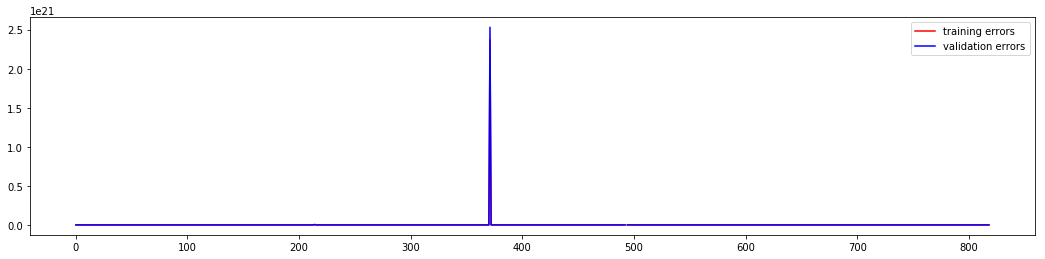

In [83]:
plt.figure(figsize=(18, 4))
plt.plot(nn_training_errors, 'r', label='training errors')
plt.plot(nn_val_errors, 'b', label='validation errors')
# plt.plot(range(100), nn_val_errors[:100], 'b')
# plt.xticks(range(100))
plt.legend()
plt.show()

In [84]:
best_relu_model = copy.deepcopy(best_model)

### tanh

In [86]:
import copy

nn_training_errors = []
nn_val_errors = []
min_error = 5
best_model = None
for l in layers:
#     print(l, end=' ')
    for a in ['tanh']:
        nn = MLP(learning_rate=0.001, batch_size=100, epoch=50, layers=l, activation=a)
        t_error, v_error = nn.train(train_x.T, train_y.T, val_x.T, val_y.T)
        e = model_error(train_x, nn.validate(train_x.T, train_y.T)[0], train_y)
        nn_training_errors.append(e)
        e = model_error(val_x, nn.validate(val_x.T, val_y.T)[0], val_y)
        nn_val_errors.append(e)
        if e < min_error:
            min_error = e
            best_model = copy.deepcopy(nn)
            print(l)
print(min_error)
np.save('./nn_train_errors_tanh.npy', nn_training_errors)
np.save('./nn_val_errors_tanh.npy', nn_val_errors)

[8]
[9]
[10]
[2, 7]
[2, 8]
[2, 9]
[2, 10]
[6, 10]
[2, 9, 10]
[2, 10, 10]
[3, 10, 10]
[4, 5, 10]
[6, 5, 10]
[6, 10, 10]
[7, 3, 10]
[7, 10, 10]
[9, 10, 10]
1.7109898534880141


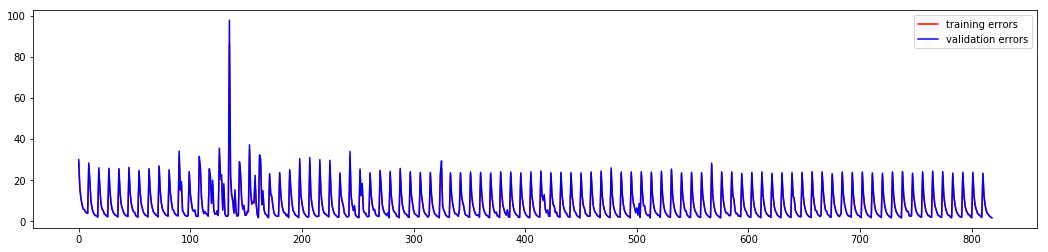

In [87]:
plt.figure(figsize=(18, 4))
plt.plot(nn_training_errors, 'r', label='training errors')
plt.plot(nn_val_errors, 'b', label='validation errors')
# plt.plot(range(100), nn_val_errors[:100], 'b')
# plt.xticks(range(100))
plt.legend()
plt.show()

In [88]:
best_tanh_model = copy.deepcopy(best_model)

## Best NN model
[10, 5, 8] with relu: giving validation error of 0.5126807874036804 

Using more epochs on full data, giving a test error of 0.5389685604232306

In [120]:
nn = MLP(learning_rate=0.001, batch_size=100, epoch=300, layers=[10,5,8], activation='relu')
nn.train(np.hstack((train_x, val_x)).T, np.hstack((train_y, val_y)).T, val_x.T, val_y.T)
e = model_error(test_x, nn.validate(test_x.T, test_y.T)[0], test_y)
print(e)

0.5389685604232306


# Problem 5

In [32]:
def get_orth_mat(X, method='qr'):
    if method == 'qr':
        u, r = np.linalg.qr(X)
    elif method == 'svd':
        u, s, vh = np.linalg.svd(X)
    elif method == 'closest_orth':
        raise ValueError('Method closest_orth is not implemented yet!')
    else:
        raise ValueError('Method %s is not valid!')
    return u
        
def flag(data_collection):
    u_collection = None
    for data in data_collection:
        u = get_orth_mat(data, method='qr')
        if u_collection is None:
            u_collection = u
        else:
            u_collection = np.hstack((u_collection, u))
    averages, s, vh = np.linalg.svd(u_collection)
    
    return averages